In [1]:
# Imports
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

import os
import sys
module_path = os.path.abspath(os.path.join(r'C:\Users\soube\OneDrive\Desktop\Hammudi\Bachelorarbeit\Repository\AP-rent-determination\tree_models.py'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tree_model_functions import *

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [7]:
# Selecting the DataSource
dataSource = r"C:\Users\soube\OneDrive\Desktop\Hammudi\Bachelorarbeit\Repository\AP-rent-determination\students_data\cleaned_data_conf_with_IQR_removal.csv"

# Selecting columns to drop out of featureList and creating LabelList
featureDropList = ["_id", "observationDate", "state", "city", "AP_community", "community_id", "base_rent", "qm2_rent", "DE_qm2_rent"]
LabelList = ["qm2_rent"]

# Create DataFrame from DataSource
try: 
    df = import_data(dataSource)
except:
    df = pd.read_csv(dataSource)


# Create list of unique states
states = df["state"].unique()



# Create list for most important features
feature_importances = []

for category in ["postcode"]:
    df[category] = df[category].astype("category")
    df[category] = df[category].cat.codes
    
df.drop(df.filter(regex = "second"), axis = 1, inplace = True)
df.drop(df.filter(regex = "third"), axis = 1, inplace = True)

Memory usage of dataframe is 79.16 MB
Memory usage after optimization is: 27.23 MB
Decreased by 65.6%


In [20]:
# Loop throug all states to train them seperately

# Create list for model scores
state_prediction_score = []

for state in states:
    df_state = df[df["state"]  == state]

    # Create feature and label lists
    y = df_state[LabelList]
    X = df_state.drop(featureDropList, axis = 1)
    feature_list = list(X.columns)

    y = np.array(y)
    X = np.array(X)

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

    # Instantiate model
    xgb = XGBRegressor(colsample_bytree= 0.8,eta= 0.1,gamma= 0,max_depth= 10,min_child_weight= 5,random_state= 0,subsample = 0.8)


    # Train the model on training data
    xgb.fit(X_train, y_train)

    # Use the Regressors's predict method on the test data
    predictions = xgb.predict(X_test)

    # Calculate the absolute errors
    errors = abs(predictions - y_test)

    # Print out the mean absolute error (mae)
    #print('Average model error:', round(np.mean(errors), 2), 'euros.')
    
    # Calculate relative prediction errors
    errors = [100 * (abs(predictions[i] - y_test[i])/ y_test[i]) for i in range(min(len(predictions), len(y_test)))]

    # Count of predictions that are at least 10% accurate
    count_good_predictions = sum(1 for i in errors if i <= 10)

    # Proportion of good predictions for the Testset
    good_predictions = round(np.mean(100 * (count_good_predictions / len(errors))), 2)
    #print('Percentage of predictions with less than 10 % deviation: ', good_predictions, '%.')

    state_prediction_score.append([state, good_predictions, df_state.shape[0]])

    # Get numerical feature importances
    importances = list(xgb.feature_importances_)

    # List of tuples with variable and importance
    feature_importances_state = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]
    feature_importances = feature_importances + feature_importances_state

In [21]:
print(state_prediction_score)

[['Schleswig-Holstein', 60.01, 2111], ['Bremen', 53.33, 642], ['Hessen', 59.8, 3440], ['Hamburg', 50.96, 2301], ['Thüringen', 64.0, 3265], ['Nordrhein-Westfalen', 61.97, 11216], ['Mecklenburg-Vorpommern', 66.67, 1971], ['Bayern', 58.6, 6131], ['Sachsen', 70.97, 15730], ['Brandenburg', 67.6, 1728], ['Berlin', 69.12, 1942], ['Saarland', 54.69, 365], ['Sachsen-Anhalt', 71.47, 6233], ['Baden-Württemberg', 53.59, 2985], ['Niedersachsen', 62.54, 3954], ['Rheinland-Pfalz', 58.46, 1241]]


In [22]:
# Convert state_prediction_score list into DataFrame
state_prediction_df = pd.DataFrame(state_prediction_score, columns = ["state", "score", "inserates"])
# Calculate the average score of the model
prediction_score = state_prediction_df["score"].mean()
print("Model score :", prediction_score, "%")

Model score : 61.48625 %


In [23]:
# Weighted prediction score

number_of_inserates = state_prediction_df["inserates"].sum()

state_prediction_df["weighted_score"] = state_prediction_df["score"] * state_prediction_df["inserates"]

prediction_score = state_prediction_df["weighted_score"].sum() / number_of_inserates

prediction_score

64.22838234618037

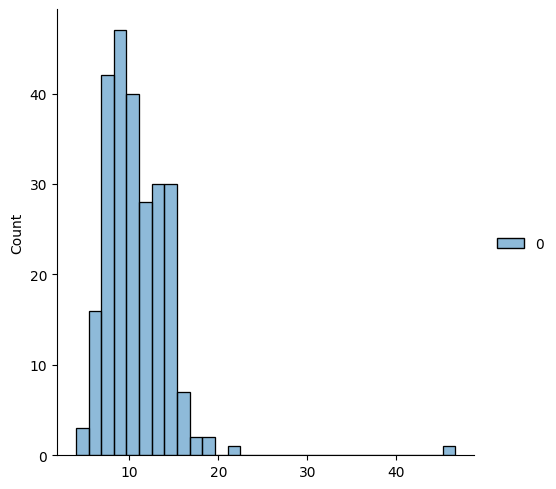

In [7]:
import seaborn as sns

sns.displot(y_test)

In [8]:
sns.displot(predictions)

### Get rid of unnnecessary Variables ###

In [9]:
feature_importances_df = pd.DataFrame(feature_importances, columns = ["Variable", "Importance"])
feature_importances_df["average_Importance"] = feature_importances_df["Importance"].groupby(feature_importances_df["Variable"]).transform("mean")
# Get the mean Importances for every Variable
mean_importances = feature_importances_df.groupby("Variable")["Importance"].mean()


cols = ["Variable", "average_Importance"]
mean_importances_list = feature_importances_df[cols].values.tolist()

# Sort and kick out all repetitive values
new_mean_importances_list = []
for i in mean_importances_list:
    if i not in new_mean_importances_list:
        new_mean_importances_list.append(i)
new_mean_importances_list = sorted(new_mean_importances_list, key = lambda x : x[1], reverse = True)

total_importances = sum(x[1] for x in new_mean_importances_list)

In [19]:
total_importances

0.9996875098950113

In [10]:
# Reset style 
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(mean_importances)))

# Make a bar chart
plt.bar(x_values, mean_importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

Text(0.5, 1.0, 'Variable Importances')

In [11]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in new_mean_importances_list]
sorted_features = [importance[0] for importance in new_mean_importances_list]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 90% of importance retained
plt.hlines(y = 0.90, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances')

Text(0.5, 1.0, 'Cumulative Importances')

In [28]:
# Find number of features for cumulative importance of 90%
# Add 1 because Python is zero-indexed
num_of_important_features = np.where(cumulative_importances > 0.9996875)[0][0] + 1
print('Number of features for 90% importance:', num_of_important_features)

Number of features for 90% importance: 83


In [29]:
#List with most important features
new_mean_importances_list = new_mean_importances_list[:num_of_important_features]

#List with most important features without importances
new_mean_importances_list_names = [item[0] for item in new_mean_importances_list]

In [30]:
# Loop throug all states to train them seperately

# Create list for model scores
state_prediction_score_imp = []

for state in states:
    df_state = df[df["state"]  == state]

    # Create feature and label lists
    y = df_state[LabelList]
    X = df_state[new_mean_importances_list_names]

    y = np.array(y)
    X = np.array(X)

    # Train test split
    important_X_train, important_X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

    # Instantiate model
    xgb = XGBRegressor(colsample_bytree= 0.8,eta= 0.1,gamma= 0,max_depth= 10,min_child_weight= 5,random_state= 0,subsample = 0.8)


    # Train the model on training data
    xgb.fit(important_X_train, y_train)

    # Use the Regressors's predict method on the test data
    predictions = xgb.predict(important_X_test)
    
    # Calculate relative prediction errors
    errors = [100 * (abs(predictions[i] - y_test[i])/ y_test[i]) for i in range(min(len(predictions), len(y_test)))]

    # Count of predictions that are at least 10% accurate
    count_good_predictions = sum(1 for i in errors if i <= 10)

    # Proportion of good predictions for the Testset
    good_predictions = round(np.mean(100 * (count_good_predictions / len(errors))), 2)
    #print('Percentage of predictions with less than 10 % deviation: ', good_predictions, '%.')

    state_prediction_score_imp.append([state, good_predictions, df_state.shape[0]])

In [31]:
print(state_prediction_score_imp)

[['Schleswig-Holstein', 73.52, 65255], ['Bremen', 74.42, 65255], ['Hessen', 70.64, 65255], ['Hamburg', 67.9, 65255], ['Thüringen', 74.73, 65255], ['Nordrhein-Westfalen', 69.25, 65255], ['Mecklenburg-Vorpommern', 77.72, 65255], ['Bayern', 66.99, 65255], ['Sachsen', 77.05, 65255], ['Brandenburg', 75.14, 65255], ['Berlin', 73.26, 65255], ['Saarland', 57.53, 65255], ['Sachsen-Anhalt', 79.39, 65255], ['Baden-Württemberg', 59.3, 65255], ['Niedersachsen', 73.45, 65255], ['Rheinland-Pfalz', 70.68, 65255]]


In [32]:
# Convert state_prediction_score list into DataFrame
state_prediction_df = pd.DataFrame(state_prediction_score_imp, columns = ["state", "score", "inserates"])
# Calculate the average score of the model
prediction_score_imp = state_prediction_df["score"].mean()
print("Model score :", prediction_score_imp, "%")

Model score : 71.310625 %


In [33]:
# Weighted prediction score

number_of_inserates = state_prediction_df["inserates"].sum()

state_prediction_df["weighted_score"] = state_prediction_df["score"] * state_prediction_df["inserates"]

prediction_score_imp = state_prediction_df["weighted_score"].sum() / number_of_inserates

prediction_score_imp

71.31062499999999

In [18]:
with open(r'C:\Users\soube\OneDrive\Desktop\Hammudi\Bachelorarbeit\Repository\AP-rent-determination\tree_models_notes\xgboost_scores.txt', 'w') as f:
    f.write("Hyperparameters:")
    f.write('\n')
    params = repr(xgb.get_params())
    f.write(params)
    f.write('\n')
    f.write('\n')
    f.write("Model score with all features:")
    f.write('\n')
    state_prediction_score = repr(state_prediction_score)
    f.write(state_prediction_score)
    f.write('\n')
    prediction_score = repr(prediction_score)
    f.write(prediction_score)
    f.write('\n')
    f.write('\n')
    f.write("Model score with important features:")
    f.write('\n')
    state_prediction_score = repr(state_prediction_score_imp)
    f.write(state_prediction_score)
    f.write('\n')
    prediction_score = repr(prediction_score_imp)
    f.write(prediction_score)